# Temperature Profile
This looks at the temperature profile, to see how it differs from the expected dry adiabat up to the LCL, followed by the moist adiabat.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import interpolate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2023-11-17 14:57:09,961 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 't_surf', 'precipitation', 'omega', 't_ref', 'dt_tg_diffusion', 
            'dt_tg_convection', 'dt_tg_condensation', 'tdt_rad', 'tdt_solar', 'klzbs']  
# Load dataset
tau_lw_ref = 1
exp_dir = 'aquaplanet/temp_tendency/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}"]
n_exp = len(exp_names)
ds_base = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])
    try:
        ds_use = ds_use[var_keep]
    except KeyError:
        remove_keys = []
        for key in var_keep:
            if key not in ds_use:
                print(f'Removing {key} from var_keep')
                remove_keys += [key]
        for key in remove_keys:
            var_keep.remove(key)
        ds_use = ds_use[var_keep]
    ds_base += [ds_use]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Get one surface dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

Also get an equivalent dataset consisting of free troposphere rather than surface values: `ds_all_ft`.

In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [4]:
# Load in dataset with surface and free troposphere across all latitudes, for given season
use_time_start = 360*2
# use_time_start = 0      # because little data

# Chose whether to only consider summer days for mean or all days
summer_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH 
use_summer = False      # if true, will set ds will only contain summer months. Do this outside tropics

ds = []  # need both all and summer day dataset
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds_base[i].sel(time=slice(use_time_start, np.inf))
        if use_summer:
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['nh']).sel(lat=slice(0, 90))  
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['sh']).sel(lat=slice(-90, 0)) 
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds += [ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))]
        pbar.update(1)
p_surface = float(ds[0].pfull[-1]) * 100

100%|██████████| 1/1 [00:00<00:00, 23.27it/s]


In [5]:
# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90
# Global
# region = 'Global'
# lat_min = 0
# lat_max = 90

lat_use_ind = np.where((np.abs(ds[0].lat) <= lat_max) & (np.abs(ds[0].lat) >= lat_min))[0]
ds = [ds[i].isel(lat=lat_use_ind).load() for i in range(n_exp)]
n_lat = ds[0].lat.shape[0]
n_pressure = ds[0].pfull.shape[0]
lat_weights = np.cos(np.deg2rad(ds[0].lat))     # latitude area weighting is just the cosine

## Hottest Day in Tropics

Here I take a single day, which is the hottest day in the tropics, and look at it in detail, to see why it deviates from the temperature profile we expect if it was convectively neutral.

In [6]:
max_surf_temp_ind = ds[0].temp[-1].argmax(dim=['lat', 'lon_time'])
# max_surf_temp_ind['lat'] = 0
# max_surf_temp_ind['lon_time'] = 9421
ds_hot_day = ds[0].isel(lat=int(max_surf_temp_ind['lat']), lon_time=int(max_surf_temp_ind['lon_time']))
ds_hot_day_next = ds[0].isel(lat=int(max_surf_temp_ind['lat']), lon_time=int(max_surf_temp_ind['lon_time'])+1)

In [7]:
p_all = ds_hot_day.pfull * 100
temp_ref_manual, temp_lcl, p_lcl = get_temp_ref(ds_hot_day.temp[-1], p_all[-1], ds_hot_day.sphum[-1], p_all)
temp_moist = moist_profile(float(temp_lcl), float(p_lcl), p_all[p_all<p_lcl])

/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/convection/simple_betts_miller.py:152: UserWarning: Changing temp_start to a float
  warnings.warn('Changing temp_start to a float')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/convection/simple_betts_miller.py:155: UserWarning: Changing p_start to a float
  warnings.warn('Changing p_start to a float')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/convection/simple_betts_miller.py:158: UserWarning: Changing sphum_start to a float
  warnings.warn('Changing sphum_start to a float')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/convection/simple_betts_miller.py:164: UserWarning: Changing p_full to a numpy array
  warnings.warn('Changing p_full to a numpy array')


In [8]:
pressure_from_level_func = scipy.interpolate.interp1d(np.arange(len(p_all)), p_all)
def lzb(k, interp_func=pressure_from_level_func):
    # Offset by -1 because fortran starts with 1, but python starts with 0
    # ds.t_ref will match exactly ds.temp if -2 used as offset, but this is not the LNB.
    if np.size(k) == 1:
        return float(interp_func(k-1))
    else:
        return interp_func(k-1)

### Temperature Profile

Here we show that in the free troposphere, the simulated temperature (blue line) is lower than the reference temperature profile that convection acts to relax it to (orange solid line).

The dotted orange line is my attempt at computing the reference temperature profile offline, but it is slightly different. One reason is that the starting temperature of ascent is larger.

The green line shows the moist adiabat, and is only shown above the LCL. Again it differs from the temperature profile, that convection is relaxing it towards.

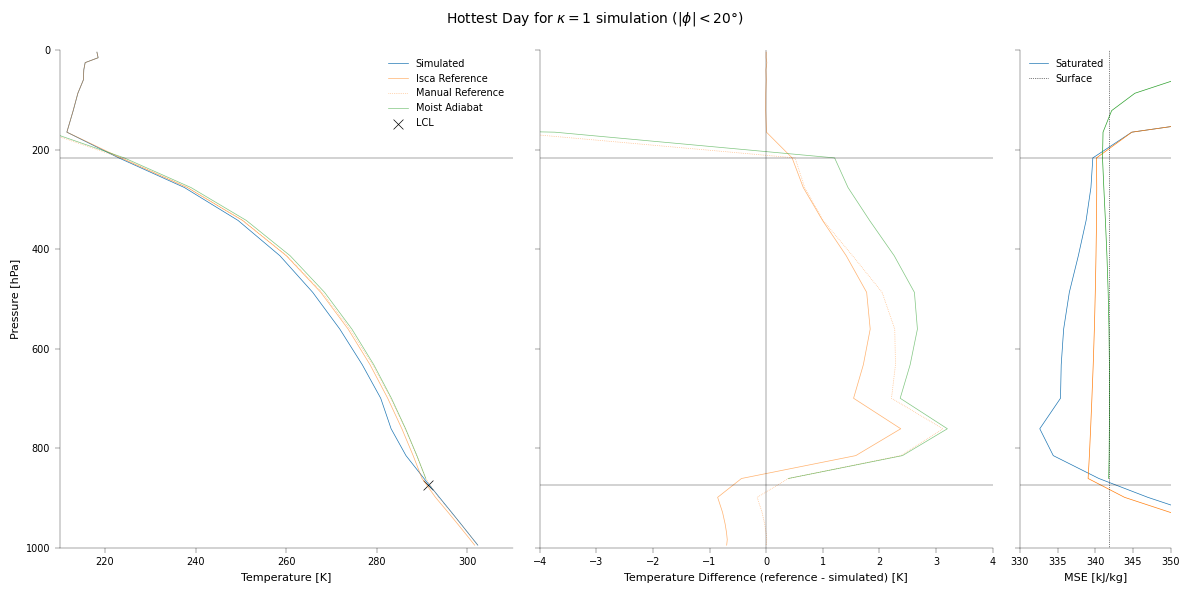

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(12,6), gridspec_kw={'width_ratios': [3, 3, 1]}, sharey=True)
ax[0].plot(ds_hot_day.temp, p_all/100, color=default_colors[0], label='Simulated')
ax[0].plot(ds_hot_day.t_ref, p_all/100, color=default_colors[1], alpha=0.6, label='Isca Reference')
ax[0].plot(temp_ref_manual, p_all/100, color=default_colors[1], alpha=0.6, label='Manual Reference', linestyle=':')
ax[0].plot(temp_moist, p_all[p_all<p_lcl]/100, color=default_colors[2], alpha=0.6, label='Moist Adiabat')
ax[0].scatter(temp_lcl, p_lcl/100, color='k', marker='x', s=50, label='LCL')
ax[0].hlines(lzb(ds_hot_day.klzbs)/100, 210, 310, color='k', lw=ax_linewidth)
ax[0].set_xlim(210, 310)
ax[0].legend()
ax[0].set_xlabel('Temperature [K]')

ax[1].plot(ds_hot_day.t_ref - ds_hot_day.temp, p_all/100, color=default_colors[1], alpha=0.6, label='Isca Reference')
ax[1].plot(temp_ref_manual - ds_hot_day.temp, p_all/100, color=default_colors[1], alpha=0.6, label='Manual Reference', linestyle=':')
ax[1].plot(temp_moist - ds_hot_day.temp[p_all<p_lcl], p_all[p_all<p_lcl]/100, color=default_colors[2], alpha=0.6, label='Moist Adiabat')
ax[1].vlines(0, 1000, 0, color='k', lw=ax_linewidth)
ax[1].hlines([p_lcl/100, lzb(ds_hot_day.klzbs)/100], -4, 4, color='k', lw=ax_linewidth)
ax[1].set_xlim(-4,4)
ax[1].set_xlabel('Temperature Difference (reference - simulated) [K]')


ax[2].plot(moist_static_energy(ds_hot_day.temp, sphum_sat(ds_hot_day.temp, p_all), ds_hot_day.height), p_all/100, color=default_colors[0],
           label='Saturated')
ax[2].plot(moist_static_energy(ds_hot_day.t_ref, sphum_sat(ds_hot_day.t_ref, p_all), ds_hot_day.height), p_all/100, color=default_colors[1])
ax[2].plot(moist_static_energy(temp_moist, sphum_sat(temp_moist, p_all[p_all<p_lcl]), ds_hot_day.height[p_all<p_lcl]), p_all[p_all<p_lcl]/100,
           color=default_colors[2])
ax[2].vlines(moist_static_energy(ds_hot_day.temp[-1], ds_hot_day.sphum[-1], ds_hot_day.height[-1]), 1000, 0, color='k', linestyle=':',
             label='Surface')
ax[2].hlines([p_lcl/100, lzb(ds_hot_day.klzbs)/100], 300, 400, color='k', lw=ax_linewidth)
ax[2].set_xlim(330, 350)
ax[2].set_xlabel('MSE [kJ/kg]')
ax[2].legend()

ax[0].invert_yaxis()
ax[0].set_ylim(1000, 0)
ax[0].set_ylabel('Pressure [hPa]')
fig.suptitle(f'Hottest Day for $\kappa={tau_lw[0]}$ simulation ($|\phi|<20\degree$)', fontsize=10)
plt.tight_layout()

### Temperature Tendency

The left plot shows that the reference temperature is higher (lower) than the simulated above (below) the LCL.

The middle plot shows the temperature tendencies on the hottest day. In particular, there is a strong cooling due to vertical diffusion at around 750hPa.

The right plot is just there to show that there is strong ascent throughout the troposphere on this day.

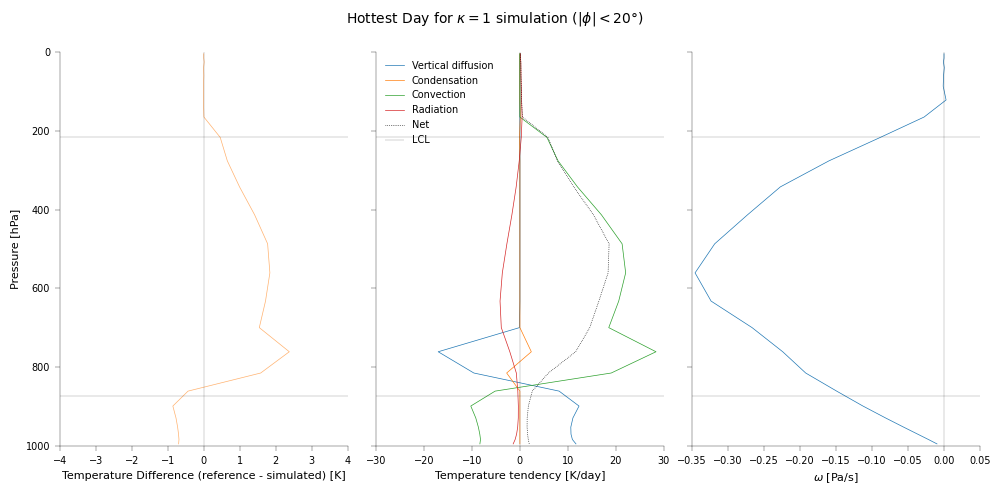

In [10]:
n_day_seconds =  24 * 60**2
fig, ax = plt.subplots(1,3, figsize=(10, 5), sharey=True)
ax[0].plot(ds_hot_day.t_ref - ds_hot_day.temp, p_all/100, color=default_colors[1], alpha=0.6)
ax[0].vlines(0, 1000, 0, color='k', lw=ax_linewidth, alpha=0.5)
ax[0].hlines([p_lcl/100, lzb(ds_hot_day.klzbs)/100], -4, 4, color='k', lw=ax_linewidth, alpha=0.5)
ax[0].scatter(temp_lcl, p_lcl/100, color='k', marker='x', s=50)
ax[0].set_xlim(-4, 4)
ax[0].set_xlabel('Temperature Difference (reference - simulated) [K]')

ax[1].plot(ds_hot_day.dt_tg_diffusion * n_day_seconds, p_all/100, label='Vertical diffusion')
ax[1].plot(ds_hot_day.dt_tg_condensation * n_day_seconds, p_all/100, label='Condensation')
ax[1].plot(ds_hot_day.dt_tg_convection * n_day_seconds, p_all/100, label='Convection')
try:
    ax[1].plot(ds_hot_day.tdt_rad * n_day_seconds, p_all/100, label='Radiation')
    ax[1].plot((ds_hot_day.dt_tg_convection + ds_hot_day.dt_tg_condensation + ds_hot_day.dt_tg_diffusion + ds_hot_day.tdt_rad) * n_day_seconds, 
               p_all/100, label='Net', color='k', linestyle=':')
except AttributeError:
    ax[1].plot((ds_hot_day.dt_tg_convection + ds_hot_day.dt_tg_condensation + ds_hot_day.dt_tg_diffusion) * n_day_seconds, 
               p_all/100, label='Net', color='k', linestyle=':')
ax[1].hlines([p_lcl/100, lzb(ds_hot_day.klzbs)/100], -30, 30, color='k', lw=ax_linewidth, alpha=0.5, label='LCL')
ax[1].vlines(0, 1000, 0, color='k', lw=ax_linewidth, alpha=0.5)
ax[1].set_xlim(-30, 30)
ax[1].set_xlabel('Temperature tendency [K/day]')
ax[1].legend()

# ax[0].set_xlim(270, 290)
ax[2].plot(ds_hot_day.omega, p_all/100)
ax[2].hlines([p_lcl/100, lzb(ds_hot_day.klzbs)/100], -0.35, 0.05, color='k', lw=ax_linewidth, alpha=0.5, label='LCL')
ax[2].vlines(0, 1000, 0, color='k', lw=ax_linewidth, alpha=0.5)
ax[2].set_xlim(-0.35, 0.05)
ax[2].set_xlabel('$\omega$ [Pa/s]')

ax[0].invert_yaxis()
ax[0].set_ylim(1000, 0)
ax[0].set_ylabel('Pressure [hPa]')
fig.suptitle(f'Hottest Day for $\kappa={tau_lw[0]}$ simulation ($|\phi|<20\degree$)', fontsize=10)
plt.tight_layout()

### Days preceeding and after the hottest day
#### Surface
In these plots, the thick lines at $p=1000hPa$ show the surface temperatures.

Here, we see that prior to the hottest day, the surface temperature starts to decrease, but there is a lag in the atmosphere, so it is still increasing.

After the hottest day, both surface and near-surface temperatures decrease.

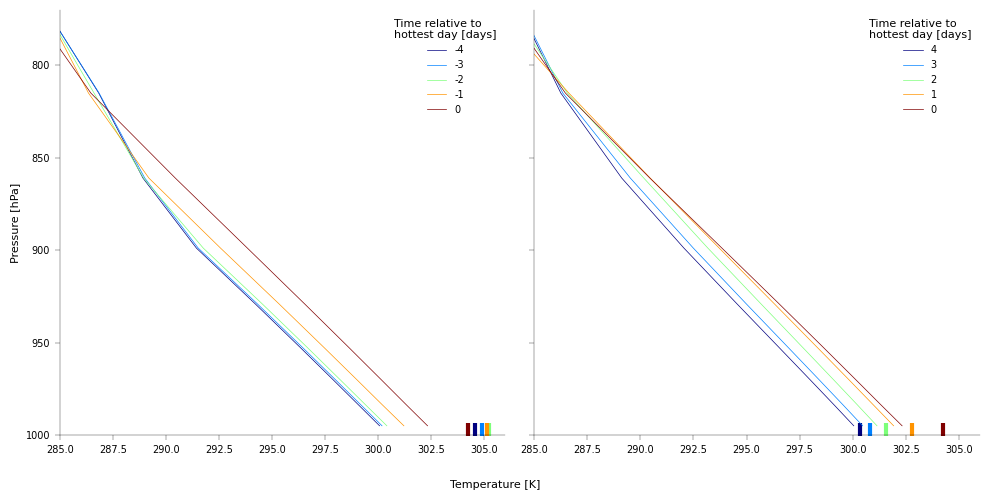

In [11]:
n_days_prior = 4
color_seq = plt.cm.jet(np.linspace(0,1,n_days_prior+1))
fig, ax = plt.subplots(1,2, figsize=(10, 5), sharey=True, sharex=True)
for i in range(n_days_prior+1):
    ds_use = ds[0].isel(lat=int(max_surf_temp_ind['lat']), lon_time=int(max_surf_temp_ind['lon_time'])-(n_days_prior-i))
    # ax[0].plot(ds_use.t_ref, p_all/100, color=color_seq[i])
    ax[0].plot(ds_use.temp, p_all/100, color=color_seq[i], label=f'{-(n_days_prior-i)}')
    ax[0].scatter(ds_use.t_surf, 1000, color=color_seq[i], marker='|', s=300, lw=3)
    # ax[0].plot(ds_use.t_ref, p_all/100, color=color_seq[i], linestyle=':')
    # temp_ref_manual_use, temp_lcl_use, p_lcl_use = get_temp_ref(ds_use.temp[-1], p_all[-1], ds_use.sphum[-1], p_all)
    # ax[0].plot(temp_ref_manual_use, p_all/100, color=color_seq[i])
for i in range(n_days_prior+1):
    ds_use = ds[0].isel(lat=int(max_surf_temp_ind['lat']), lon_time=int(max_surf_temp_ind['lon_time'])+n_days_prior-i)
    # ax[1].plot(ds_use.t_ref - ds_hot_day.t_ref, p_all/100, color=color_seq[i])
    ax[1].plot(ds_use.temp, p_all/100, color=color_seq[i], label=f'{n_days_prior-i}')
    ax[1].scatter(ds_use.t_surf, 1000, color=color_seq[i], marker='|', s=300, lw=3)
    # ax[1].plot(temp_ref_manual_use, p_all/100, color=color_seq[i])
ax[0].legend(title='Time relative to\nhottest day [days]')
ax[1].legend(title='Time relative to\nhottest day [days]')
ax[0].invert_yaxis()
ax[0].set_xlim(285, 306)
ax[0].set_ylim(1000, 770)
fig.supxlabel('Temperature [K]', fontsize=8)
ax[0].set_ylabel('Pressure [hPa]')
plt.tight_layout()

#### Temperature profile relative to convective reference profile
Here I plot the temperature profiles relative to that of the hottest day. The dotted lines show the reference profiles. The thick lines at $p=1000hPa$ show the surface temperatures relative to the lowest atmospheric level temperature of the hottest day.

Here, we see that 4 days prior to the hottest day, the temperature profile is almost exactly the convectively neutral one, but soon starts to deviate.

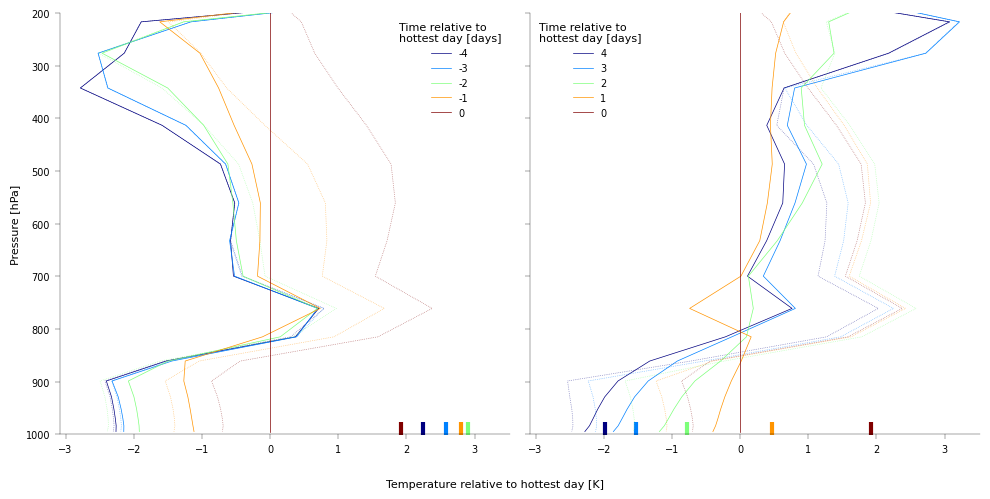

In [12]:
fig, ax = plt.subplots(1,2, figsize=(10, 5), sharey=True, sharex=True)
for i in range(n_days_prior+1):
    ds_use = ds[0].isel(lat=int(max_surf_temp_ind['lat']), lon_time=int(max_surf_temp_ind['lon_time'])-(n_days_prior-i))
    ax[0].plot(ds_use.temp - ds_hot_day.temp, p_all/100, color=color_seq[i], label=f'{-(n_days_prior-i)}')
    ax[0].plot(ds_use.t_ref - ds_hot_day.temp, p_all/100, color=color_seq[i], linestyle=':', alpha=0.6)
    ax[0].scatter(ds_use.t_surf - ds_hot_day.temp[-1], 1000, color=color_seq[i], marker='|', s=300, lw=3)
    # temp_ref_manual_use, temp_lcl_use, p_lcl_use = get_temp_ref(ds_use.temp[-1], p_all[-1], ds_use.sphum[-1], p_all)
    # ax[0].plot(temp_ref_manual_use, p_all/100, color=color_seq[i])
for i in range(n_days_prior+1):
    ds_use = ds[0].isel(lat=int(max_surf_temp_ind['lat']), lon_time=int(max_surf_temp_ind['lon_time'])+n_days_prior-i)
    ax[1].plot(ds_use.temp - ds_hot_day.temp, p_all/100, color=color_seq[i], label=f'{n_days_prior-i}')
    ax[1].plot(ds_use.t_ref - ds_hot_day.temp, p_all/100, color=color_seq[i], linestyle=':', alpha=0.6)
    ax[1].scatter(ds_use.t_surf - ds_hot_day.temp[-1], 1000, color=color_seq[i], marker='|', s=300, lw=3)
    # ax[1].scatter(ds_use.t_surf - ds_hot_day.t_surf, 1000, color=color_seq[i], marker='x', s=50)
    # ax[1].plot(temp_ref_manual_use, p_all/100, color=color_seq[i])
ax[0].invert_yaxis()
ax[0].set_ylim(1000, 200)
ax[0].legend(title='Time relative to\nhottest day [days]')
ax[1].legend(title='Time relative to\nhottest day [days]')
fig.supxlabel('Temperature relative to hottest day [K]', fontsize=8)
ax[0].set_ylabel('Pressure [hPa]')
plt.tight_layout()
# fig.savefig(f"/Users/joshduffield/Desktop/temp_rel.jpeg",
#                     dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

#### Vertical wind speed, $\omega$
Here, we see than there is a transition from descent to ascent in the days proceeding the hottest day, and that the hottest day has the largest ascent.

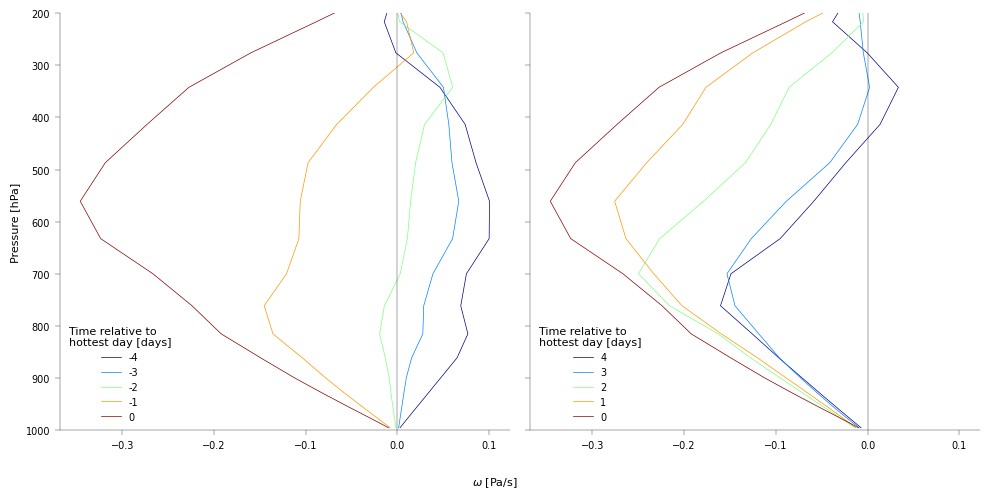

In [13]:
fig, ax = plt.subplots(1,2, figsize=(10, 5), sharey=True, sharex=True)
for i in range(n_days_prior+1):
    ds_use = ds[0].isel(lat=int(max_surf_temp_ind['lat']), lon_time=int(max_surf_temp_ind['lon_time'])-(n_days_prior-i))
    ax[0].plot(ds_use.omega, p_all/100, color=color_seq[i], label=f'{-(n_days_prior-i)}')
    ds_use = ds[0].isel(lat=int(max_surf_temp_ind['lat']), lon_time=int(max_surf_temp_ind['lon_time'])+n_days_prior-i)
    ax[1].plot(ds_use.omega, p_all/100, color=color_seq[i], label=f'{n_days_prior-i}')
    # temp_ref_manual_use, temp_lcl_use, p_lcl_use = get_temp_ref(ds_use.temp[-1], p_all[-1], ds_use.sphum[-1], p_all)
    # ax[0].plot(temp_ref_manual_use, p_all/100, color=color_seq[i])
ax[0].vlines(0, 1000, 0, color='k', lw=ax_linewidth)
ax[1].vlines(0, 1000, 0, color='k', lw=ax_linewidth)
ax[0].invert_yaxis()
ax[0].legend(title='Time relative to\nhottest day [days]')
ax[1].legend(title='Time relative to\nhottest day [days]')
ax[0].set_ylim(1000, 200)
fig.supxlabel('$\omega$ [Pa/s]', fontsize=8)
ax[0].set_ylabel('Pressure [hPa]')
plt.tight_layout()

#### Temperature Tendency
This shows how the net (solid lines) and vertical diffusion (dotted) vary before and after the hottest day.

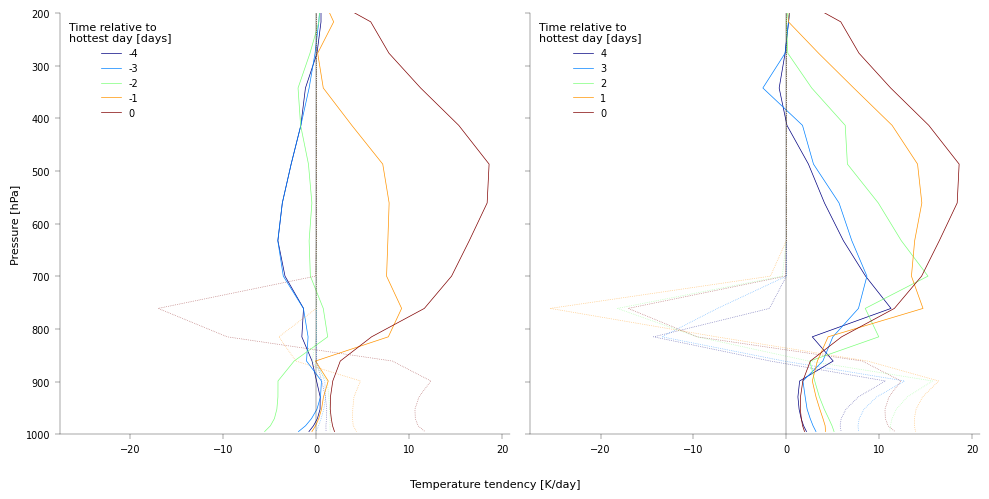

In [14]:
fig, ax = plt.subplots(1,2, figsize=(10, 5), sharey=True, sharex=True)
for i in range(n_days_prior+1):
    ds_use = ds[0].isel(lat=int(max_surf_temp_ind['lat']), lon_time=int(max_surf_temp_ind['lon_time'])-(n_days_prior-i))
    ax[0].plot((ds_use.dt_tg_diffusion+ds_use.dt_tg_convection+ds_use.dt_tg_condensation + ds_hot_day.tdt_rad) * n_day_seconds, p_all/100, 
           color=color_seq[i], label=f'{-(n_days_prior-i)}')
    ax[0].plot(ds_use.dt_tg_diffusion * n_day_seconds, p_all/100, color=color_seq[i], linestyle=':', alpha=0.6)
for i in range(n_days_prior+1):
    ds_use = ds[0].isel(lat=int(max_surf_temp_ind['lat']), lon_time=int(max_surf_temp_ind['lon_time'])+n_days_prior-i)
    ax[1].plot((ds_use.dt_tg_diffusion+ds_use.dt_tg_convection+ds_use.dt_tg_condensation + ds_hot_day.tdt_rad) * n_day_seconds, p_all/100, 
           color=color_seq[i], label=f'{n_days_prior-i}')
    ax[1].plot(ds_use.dt_tg_diffusion * n_day_seconds, p_all/100, color=color_seq[i], linestyle=':', alpha=0.6)
ax[0].invert_yaxis()
ax[0].vlines(0, 1000, 0, color='k', lw=ax_linewidth)
ax[1].vlines(0, 1000, 0, color='k', lw=ax_linewidth)
ax[0].legend(title='Time relative to\nhottest day [days]')
ax[1].legend(title='Time relative to\nhottest day [days]')
ax[0].set_ylim(1000, 200)
ax[0].set_ylabel('Pressure [hPa]')
fig.supxlabel('Temperature tendency [K/day]', fontsize=8)
plt.tight_layout()
# fig.savefig(f"/Users/joshduffield/Desktop/temp_tend.jpeg",
#                     dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Influence of $\omega$
From the above plots, it was noticeable that the hottest day had a very negative $\omega$. 

Below, I show that there is a strong correlation for how negative $\omega$ is, and by how much the simulated temperature profile differs from the convective reference profile.

I.e. the more ascent there is, the less influence convection has on the temperature profile.

In [71]:
# See if deviation from reference profile is related to fast ascent
pressure_lzb = lzb(ds[0].klzbs.where(ds[0].klzbs>=1))/100           # pressure of LZB
# highest altitude reached by convection is where temperature tendency is first non zero due to convection
pressure_min_conv = ds[0].pfull.where(np.abs(ds[0].dt_tg_convection*n_day_seconds)>0.01).min(dim='pfull')   
# p_use = np.logical_and(p_all > 200 * 100, p_all < 900 * 100)  # Avoid surface and far above LNB

# If LZB at lower altitude, replace conv pressure with this
pressure_min_conv.values = np.asarray([pressure_lzb, pressure_min_conv]).max(axis=0)        
p_use = np.logical_and(ds[0].pfull>=pressure_min_conv, ds[0].pfull<900)
# p_use = np.logical_and(p_use, pressure_min_conv>600)

omega_max = ds[0].omega.where(p_use).min(dim=['pfull'])
ref_temp_dev_max = (ds[0].t_ref - ds[0].temp).where(p_use).max(dim=['pfull'])
diffusion_tendancy_max = ds[0].dt_tg_diffusion.where(p_use).min(dim=['pfull'])
mse_dev_max = (moist_static_energy(ds[0].temp[-1], ds[0].sphum[-1], ds[0].height[-1]) - 
               moist_static_energy(ds[0].temp, sphum_sat(ds[0].temp, p_all), ds[0].height)).where(p_use)
mse_dev_max = mse_dev_max.max(dim=['pfull'])*1000/c_p       # convert into Kelvin

mse_dev_max_ref = (moist_static_energy(ds[0].temp[-1], ds[0].sphum[-1], ds[0].height[-1]) - 
                   moist_static_energy(ds[0].t_ref, sphum_sat(ds[0].t_ref, p_all), ds[0].height)).where(p_use)
mse_dev_max_ref = mse_dev_max_ref.max(dim=['pfull'])*1000/c_p

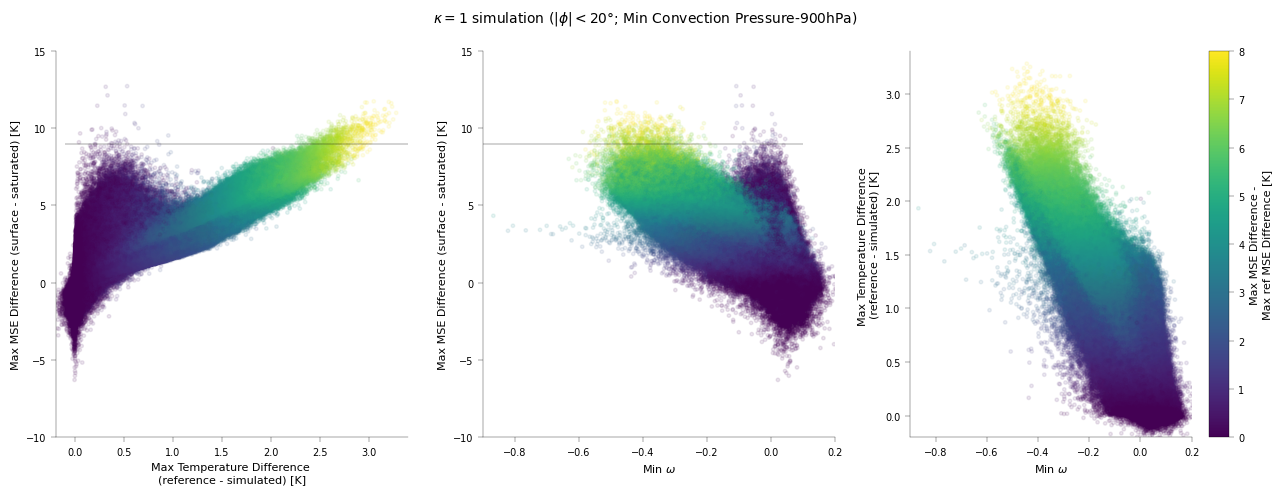

In [77]:
mse_dev_thresh = 9
fig, ax = plt.subplots(1, 3, figsize=(13, 5))
p_conv_use_thresh = 900             # only show days with min convective pressure less than this
p_conv_use = pressure_min_conv < p_conv_use_thresh
lat_ind_scatter = None            # combine all latitudes
# lat_ind_scatter = -1
if lat_ind_scatter is not None:
    p_conv_use = np.logical_and(p_conv_use, np.abs(ref_temp_dev_max.lat)==np.unique(np.abs(ref_temp_dev_max.lat))[lat_ind_scatter])

# Color by convective pressure
# ax[0].scatter(ref_temp_dev_max.where(p_conv_use), mse_dev_max.where(p_conv_use), alpha=0.1, 
#               c=pressure_min_conv.where(p_conv_use), vmin=200, vmax=p_conv_use_thresh)
# ax[1].scatter(omega_max.where(p_conv_use), mse_dev_max.where(p_conv_use), alpha=0.1, 
#               c=pressure_min_conv.where(p_conv_use), vmin=200, vmax=p_conv_use_thresh)
# ax[2].scatter(omega_max.where(p_conv_use), ref_temp_dev_max.where(p_conv_use), alpha=0.1, 
#               c=pressure_min_conv.where(p_conv_use), vmin=200, vmax=p_conv_use_thresh)
# im = ax[2].scatter(0, 0, c=500, s=0, vmin=200, vmax=p_conv_use_thresh)       # add a marker you can't see, for the colorbar
# plt.colorbar(im, label='Min Convective Pressure [hPa]')

# Color by latitude
# ax[0].scatter(ref_temp_dev_max.where(p_conv_use), mse_dev_max.where(p_conv_use), alpha=0.1, 
#               c=np.abs(ref_temp_dev_max.lat).where(p_conv_use), vmin=0, vmax=20)
# ax[1].scatter(omega_max.where(p_conv_use), mse_dev_max.where(p_conv_use), alpha=0.1, 
#               c=np.abs(ref_temp_dev_max.lat).where(p_conv_use), vmin=0, vmax=20)
# ax[2].scatter(omega_max.where(p_conv_use), ref_temp_dev_max.where(p_conv_use), alpha=0.1, 
#               c=np.abs(ref_temp_dev_max.lat).where(p_conv_use), vmin=0, vmax=20)
# im = ax[2].scatter(0, 0, c=5, s=0, vmin=0, vmax=20)       # add a marker you can't see, for the colorbar
# plt.colorbar(im, label='Absolute latitude [deg]')

# Color by difference between profile and convective profile
ax[0].scatter(ref_temp_dev_max.where(p_conv_use), mse_dev_max.where(p_conv_use), alpha=0.1, 
              c=(mse_dev_max-mse_dev_max_ref).where(p_conv_use), vmin=0, vmax=8)
ax[1].scatter(omega_max.where(p_conv_use), mse_dev_max.where(p_conv_use), alpha=0.1, 
              c=(mse_dev_max-mse_dev_max_ref).where(p_conv_use), vmin=0, vmax=8)
ax[2].scatter(omega_max.where(p_conv_use), ref_temp_dev_max.where(p_conv_use), alpha=0.1, 
              c=(mse_dev_max-mse_dev_max_ref).where(p_conv_use), vmin=0, vmax=8)
im = ax[2].scatter(0, 0, c=3, s=0, vmin=0, vmax=8)       # add a marker you can't see, for the colorbar
plt.colorbar(im, label='Max MSE Difference -\nMax ref MSE Difference [K]')

ax[0].hlines(mse_dev_thresh, -0.1, 3.4, color='k', lw=ax_linewidth)
ax[1].hlines(mse_dev_thresh, -0.9, 0.1, color='k', lw=ax_linewidth)
ax[0].set_xlabel('Max Temperature Difference \n(reference - simulated) [K]')
ax[0].set_ylabel('Max MSE Difference (surface - saturated) [K]')
ax[1].set_xlabel('Min $\omega$')
ax[1].set_ylabel('Max MSE Difference (surface - saturated) [K]')
ax[2].set_xlabel('Min $\omega$')
ax[2].set_ylabel('Max Temperature Difference \n(reference - simulated) [K]')
ax[0].set_ylim(-10, 15)
ax[1].set_ylim(-10, 15)
ax[0].set_xlim(-0.2, 3.4)
ax[2].set_ylim(-0.2, 3.4)
ax[1].set_xlim(-0.9, 0.2)
ax[2].set_xlim(-0.9, 0.2)
# fig.suptitle(f'$\kappa={tau_lw[0]}$ simulation ($|\phi|<20\degree$; 200hPa-900hPa)', fontsize=10)
if lat_ind_scatter is None:
    fig.suptitle(f'$\kappa={tau_lw[0]}$ simulation ($|\phi|<20\degree$; Min Convection Pressure-900hPa)', fontsize=10)
else:
    fig.suptitle(f'$\kappa={tau_lw[0]}$ simulation ($|\phi|={round(np.unique(np.abs(ref_temp_dev_max.lat))[lat_ind_scatter], 1)}\degree$; '
                 f'Min Convection Pressure-900hPa)', fontsize=10)
plt.tight_layout()

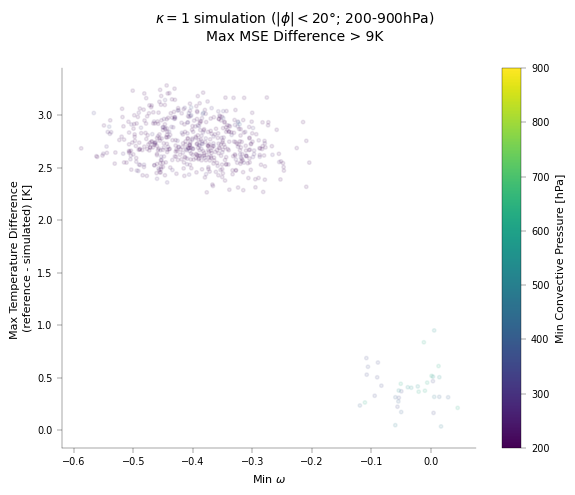

In [17]:
# Plot only days with large MSE deviation
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.scatter(omega_max.where(mse_dev_max>mse_dev_thresh), ref_temp_dev_max.where(mse_dev_max>mse_dev_thresh), 
           c=pressure_min_conv.where(mse_dev_max>mse_dev_thresh), alpha=0.1, vmin=200, vmax=900)
im = ax.scatter(0, 0, c=500, s=0, vmin=200, vmax=900)
plt.colorbar(im, label='Min Convective Pressure [hPa]')
ax.set_xlabel('Min $\omega$')
ax.set_ylabel('Max Temperature Difference \n(reference - simulated) [K]')
fig.suptitle(f'$\kappa={tau_lw[0]}$ simulation ($|\phi|<20\degree$; 200-900hPa)\nMax MSE Difference > {mse_dev_thresh}K', fontsize=10)
plt.tight_layout()

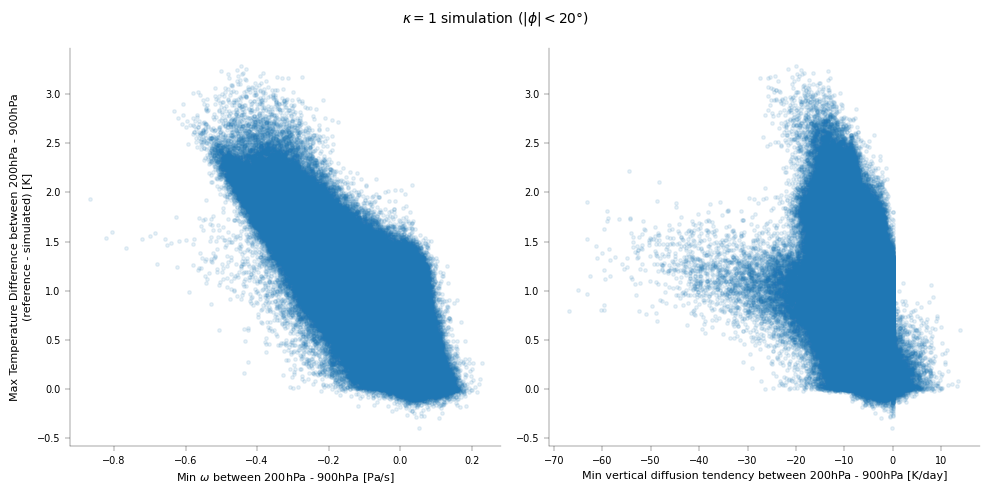

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(omega_max, ref_temp_dev_max, alpha=0.1)
ax[1].scatter(diffusion_tendancy_max * 24 * 60 ** 2, ref_temp_dev_max, alpha=0.1)
ax[0].set_ylabel('Max Temperature Difference between 200hPa - 900hPa\n(reference - simulated) [K]')
ax[0].set_xlabel('Min $\omega$ between 200hPa - 900hPa [Pa/s]')
ax[1].set_xlabel('Min vertical diffusion tendency between 200hPa - 900hPa [K/day]')
fig.suptitle(f'$\kappa={tau_lw[0]}$ simulation ($|\phi|<20\degree$)', fontsize=10)
plt.tight_layout()

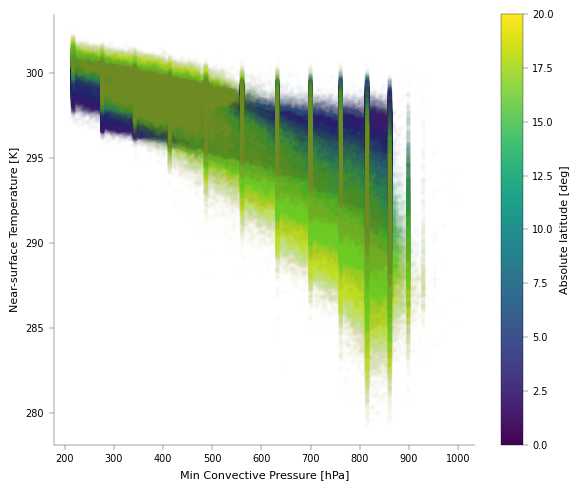

In [19]:
# Show hottest days have convection that reaches a higher altitude (lower pressure)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.scatter(pressure_min_conv, ds[0].temp[-1], c=np.abs(ds[0].lat.where(ds[0].temp[-1]>0)), alpha=0.01, vmin=0, vmax=20)
im = ax.scatter(250, 300, c=5, s=0, vmin=0, vmax=20)       # add a marker you can't see, for the colorbar
plt.colorbar(im, label='Absolute latitude [deg]')
ax.set_xlabel('Min Convective Pressure [hPa]')
ax.set_ylabel('Near-surface Temperature [K]')
plt.tight_layout()

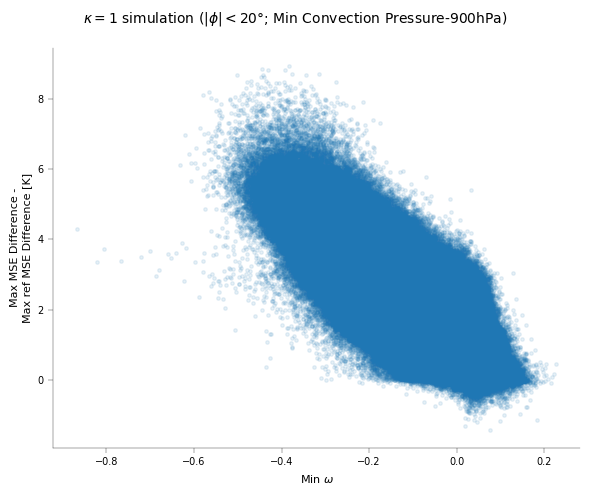

In [80]:
# Show that it is not really possible to differ from convectively neutral profile without large ascent
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.scatter(omega_max, mse_dev_max-mse_dev_max_ref, alpha=0.1)
ax.set_xlabel('Min $\omega$')
ax.set_ylabel('Max MSE Difference -\nMax ref MSE Difference [K]')
fig.suptitle(f'$\kappa={tau_lw[0]}$ simulation ($|\phi|<20\degree$; Min Convection Pressure-900hPa)', fontsize=10)
plt.tight_layout()

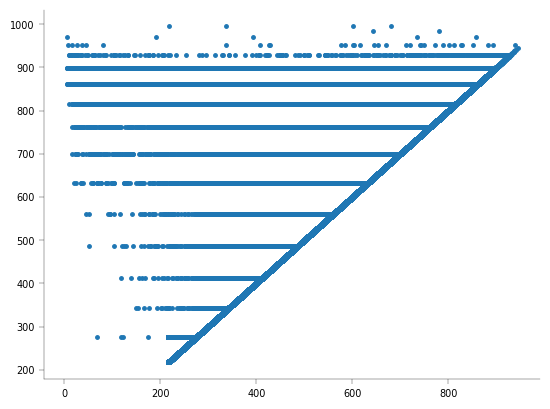

In [20]:
plt.scatter(pressure_lzb, pressure_min_conv)

### Compare Days of large $\omega$ to small $\omega$

Here I show explicitly that convection has more influence on the temperature profile for days with small ascent or descent, to those with large ascent.

In [21]:
ds_low_wind = ds[0].where(omega_max > -0.05)
mse_surf_low_wind = moist_static_energy(ds_low_wind.temp[-1], ds_low_wind.sphum[-1], ds_low_wind.height[-1])
mse_sat_low_wind = moist_static_energy(ds_low_wind.temp, sphum_sat(ds_low_wind.temp, p_all), ds_low_wind.height)

ds_high_wind = ds[0].where(omega_max <= -0.05)
mse_surf_high_wind = moist_static_energy(ds_high_wind.temp[-1], ds_high_wind.sphum[-1], ds_high_wind.height[-1])
mse_sat_high_wind = moist_static_energy(ds_high_wind.temp, sphum_sat(ds_high_wind.temp, p_all), ds_high_wind.height)

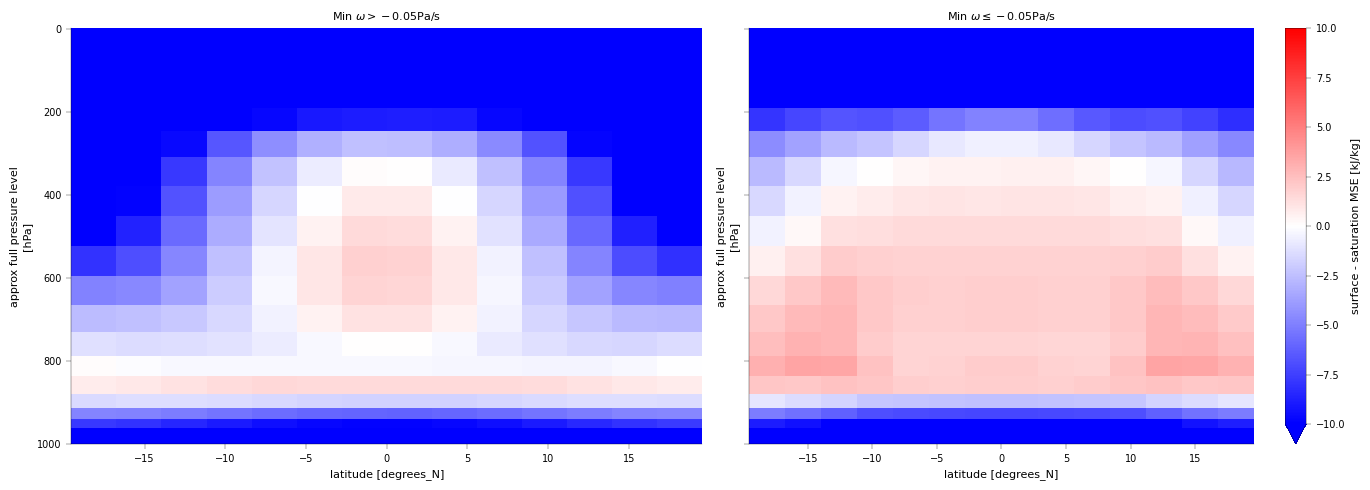

In [22]:
fig, ax = plt.subplots(1,2, figsize=(14, 5), sharex=True, sharey=True)
(-mse_sat_low_wind+mse_surf_low_wind).mean(dim='lon_time').plot.pcolormesh(ax=ax[0], yincrease=False, 
                                                                           vmin=-10, vmax=10, cmap='bwr', x='lat', add_colorbar=False)
(-mse_sat_high_wind+mse_surf_high_wind).mean(dim='lon_time').plot.pcolormesh(ax=ax[1], yincrease=False, 
                                                                           vmin=-10, vmax=10, cmap='bwr', x='lat', 
                                                                             cbar_kwargs={'label': 'surface - saturation MSE [kJ/kg]'})
ax[0].set_title('Min $\omega > -0.05$Pa/s')
ax[1].set_title('Min $\omega \leq -0.05$Pa/s')
plt.tight_layout()

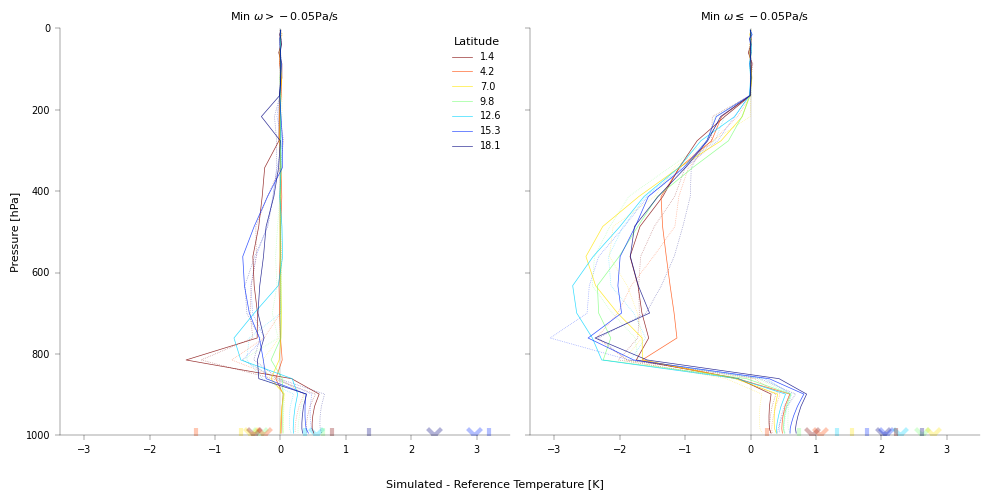

In [23]:
color_seq_lat = plt.cm.jet(np.linspace(0,1,int(n_lat/2)))
color_seq_lat = np.concatenate([color_seq_lat, color_seq_lat[::-1]], axis=0)
fig, ax = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)
for i in range(n_lat):
    for j, ds_use in enumerate([ds_low_wind.isel(lat=i), ds_high_wind.isel(lat=i)]):
        ds_use = ds_use.isel(lon_time=int(ds_use.temp[-1].argmax(dim='lon_time')))
        ax[j].plot(ds_use.temp - ds_use.t_ref, p_all/100, color=color_seq_lat[i], 
                linestyle=':' if ds_use.lat<0 else '-', alpha=0.5 if ds_use.lat<0 else 0.8, 
                label=round(float(ds_use.lat), 1) if ds_use.lat>0 else None)
        ax[j].scatter(ds_use.t_surf - ds_hot_day.t_ref[-1], 1000, color=color_seq_lat[i], marker='x' if ds_use.lat<0 else '|', s=100, lw=3, alpha=0.3)
ax[0].invert_yaxis()
ax[0].set_ylim(1000, 0)
ax[0].legend(title='Latitude')
ax[0].vlines(0, 1000, 0, color='k', lw=ax_linewidth, alpha=0.5)
ax[1].vlines(0, 1000, 0, color='k', lw=ax_linewidth, alpha=0.5)
ax[0].set_title('Min $\omega > -0.05$Pa/s')
ax[1].set_title('Min $\omega \leq -0.05$Pa/s')
fig.supxlabel('Simulated - Reference Temperature [K]', fontsize=8)
ax[0].set_ylabel('Pressure [hPa]')
plt.tight_layout()
# fig.savefig(f"/Users/joshduffield/Desktop/wind_comp.pdf",
#                     dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Level of Neutral Buoyancy
On the left, I plot the mean LNB vs latitude for the tropics. On the right, I average across the whole of the tropics, to plot LNB as a function of temperature percentile.

Clearly, on the coldest days, the LNB is very low, suggesting that convection is not really happening on these days.

In [24]:
lzbs_mean_lat = lzb(ds[0].klzbs.mean(dim='lon_time'))
lzbs_std_lat = lzb(ds[0].klzbs.std(dim='lon_time'))

quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
klzb_quant3 = np.zeros((n_exp, n_lat, n_quant))      # klzb as function of temp quantile
klzb_quant3_std = np.zeros((n_exp, n_lat, n_quant))      # klzb as function of temp quantile
with tqdm(total=n_exp*n_quant*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for k in range(n_lat):
            for j, quant in enumerate(quant_plot):
                use_ind = get_quant_ind(ds[i].temp[-1, k], quant, 0.5, 0.5)
                klzb_quant3[i, k, j] = ds[i].klzbs[k, use_ind].mean(dim='lon_time')
                klzb_quant3_std[i, k, j] = ds[i].klzbs[k, use_ind].std(dim='lon_time')
                pbar.update(1)

100%|██████████| 1386/1386 [00:10<00:00, 131.11it/s]


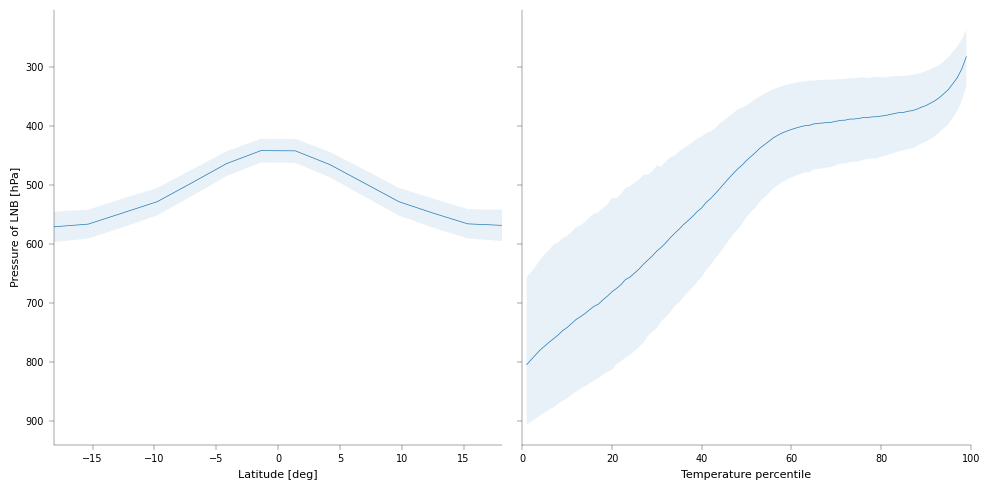

In [25]:
fig, ax = plt.subplots(1,2, figsize=(10, 5), sharey=True)
ax[0].plot(ds[0].lat, lzbs_mean_lat/100)
ax[0].fill_between(ds[0].lat, (lzbs_mean_lat-lzbs_std_lat)/100, (lzbs_mean_lat+lzbs_std_lat)/100 ,alpha=0.1, facecolor=default_colors[0])
ax[0].invert_yaxis()
ax[0].set_xlabel('Latitude [deg]')
ax[0].set_ylabel('Pressure of LNB [hPa]')
ax[0].set_xlim(ds[0].lat[0], ds[0].lat[-1])

ax[1].plot(quant_plot, lzb(np.average(klzb_quant3[0], axis=0, weights=lat_weights))/100)
ax[1].fill_between(quant_plot, lzb(np.average(klzb_quant3[0]-klzb_quant3_std[0], axis=0, weights=lat_weights))/100, 
                   lzb(np.average(klzb_quant3[0]+klzb_quant3_std[0], axis=0, weights=lat_weights))/100 ,alpha=0.1, facecolor=default_colors[0])
ax[1].set_xlim(0, 100)
ax[1].set_xlabel('Temperature percentile')
plt.tight_layout()

In [68]:
# Consider days with small temp deviation from reference but large saturated MSE deviation from surface
lat_ind_subset, lontime_ind_subset = np.where(np.logical_and(mse_dev_max>10, omega_max<-0.3))
# lat_ind_subset, lontime_ind_subset = np.where(np.logical_and(mse_dev_max>7, omega_max>-0.05))
# lat_ind_subset, lontime_ind_subset = np.where(np.logical_and(pressure_min_conv>600, np.logical_and(mse_dev_max>7, omega_max>-0.05)))
# lat_ind_subset, lontime_ind_subset = np.where(np.logical_and(pressure_min_conv<400, ds[0].klzbs==10))
# lat_ind_subset, lontime_ind_subset = np.where(np.logical_and(mse_dev_max>10, np.logical_and(ref_temp_dev_max>0.4,ref_temp_dev_max<0.5)))
ind_subset_use = 3
ds_subset = ds[0].isel(lat=lat_ind_subset[ind_subset_use], lon_time=lontime_ind_subset[ind_subset_use])

temp_ref_manual_subset, temp_lcl_subset, p_lcl_subset = get_temp_ref(ds_subset.temp[-1], p_all[-1], ds_subset.sphum[-1], p_all)
temp_moist_subset = moist_profile(float(temp_lcl_subset), float(p_lcl_subset), p_all[p_all<p_lcl_subset])

/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/convection/simple_betts_miller.py:152: UserWarning: Changing temp_start to a float
  warnings.warn('Changing temp_start to a float')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/convection/simple_betts_miller.py:155: UserWarning: Changing p_start to a float
  warnings.warn('Changing p_start to a float')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/convection/simple_betts_miller.py:158: UserWarning: Changing sphum_start to a float
  warnings.warn('Changing sphum_start to a float')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/convection/simple_betts_miller.py:164: UserWarning: Changing p_full to a numpy array
  warnings.warn('Changing p_full to a numpy array')


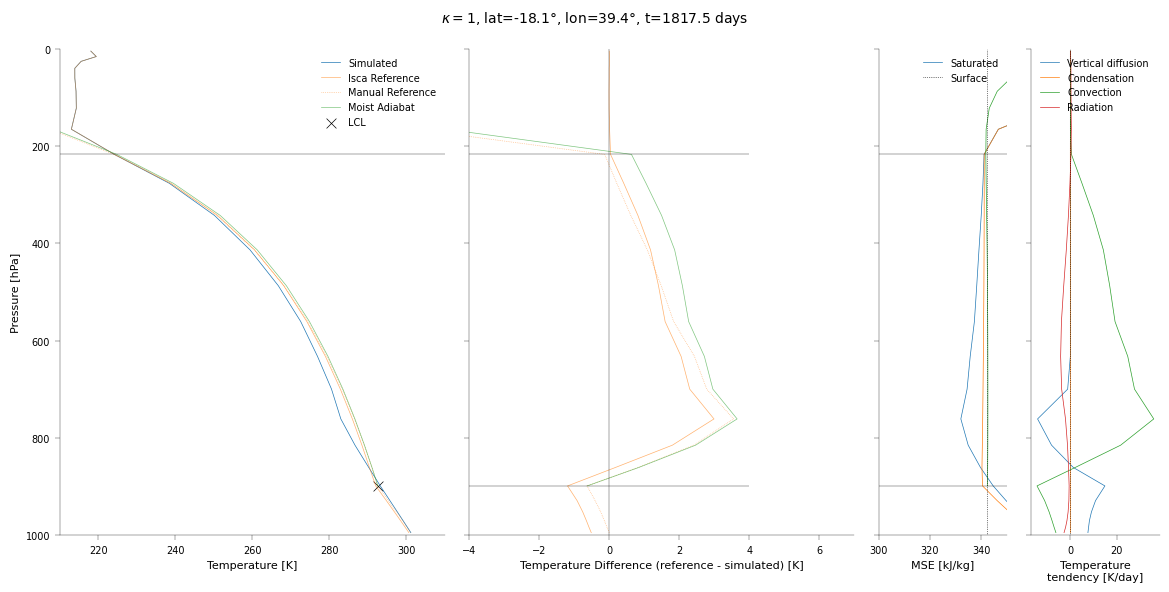

In [69]:
fig, ax = plt.subplots(1, 4, figsize=(12,6), gridspec_kw={'width_ratios': [3, 3, 1, 1]}, sharey=True)
ax[0].plot(ds_subset.temp, p_all/100, color=default_colors[0], label='Simulated')
ax[0].plot(ds_subset.t_ref, p_all/100, color=default_colors[1], alpha=0.6, label='Isca Reference')
ax[0].plot(temp_ref_manual_subset, p_all/100, color=default_colors[1], alpha=0.6, label='Manual Reference', linestyle=':')
ax[0].plot(temp_moist_subset, p_all[p_all<p_lcl_subset]/100, color=default_colors[2], alpha=0.6, label='Moist Adiabat')
ax[0].scatter(temp_lcl_subset, p_lcl_subset/100, color='k', marker='x', s=50, label='LCL')
ax[0].hlines(lzb(ds_subset.klzbs)/100, 210, 310, color='k', lw=ax_linewidth)
ax[0].set_xlim(210, 310)
ax[0].legend()
ax[0].set_xlabel('Temperature [K]')

ax[1].plot(ds_subset.t_ref - ds_subset.temp, p_all/100, color=default_colors[1], alpha=0.6, label='Isca Reference')
ax[1].plot(temp_ref_manual_subset - ds_subset.temp, p_all/100, color=default_colors[1], alpha=0.6, label='Manual Reference', linestyle=':')
ax[1].plot(temp_moist_subset - ds_subset.temp[p_all<p_lcl_subset], p_all[p_all<p_lcl_subset]/100, color=default_colors[2], alpha=0.6, label='Moist Adiabat')
ax[1].vlines(0, 1000, 0, color='k', lw=ax_linewidth)
ax[1].hlines([p_lcl_subset/100, lzb(ds_subset.klzbs)/100], -4, 4, color='k', lw=ax_linewidth)
ax[1].set_xlim(-4,7)
ax[1].set_xlabel('Temperature Difference (reference - simulated) [K]')


ax[2].plot(moist_static_energy(ds_subset.temp, sphum_sat(ds_subset.temp, p_all), ds_subset.height), p_all/100, color=default_colors[0],
           label='Saturated')
ax[2].plot(moist_static_energy(ds_subset.t_ref, sphum_sat(ds_subset.t_ref, p_all), ds_subset.height), p_all/100, color=default_colors[1])
ax[2].plot(moist_static_energy(temp_moist_subset, sphum_sat(temp_moist_subset, p_all[p_all<p_lcl_subset]), ds_subset.height[p_all<p_lcl_subset]), p_all[p_all<p_lcl_subset]/100,
           color=default_colors[2])
ax[2].vlines(moist_static_energy(ds_subset.temp[-1], ds_subset.sphum[-1], ds_subset.height[-1]), 1000, 0, color='k', linestyle=':',
             label='Surface')
ax[2].hlines([p_lcl_subset/100, lzb(ds_subset.klzbs)/100], 300, 400, color='k', lw=ax_linewidth)
ax[2].set_xlim(300, 350)
ax[2].set_xlabel('MSE [kJ/kg]')
ax[2].legend()

ax[3].plot(ds_subset.dt_tg_diffusion * n_day_seconds, p_all/100, label='Vertical diffusion')
ax[3].plot(ds_subset.dt_tg_condensation * n_day_seconds, p_all/100, label='Condensation')
ax[3].plot(ds_subset.dt_tg_convection * n_day_seconds, p_all/100, label='Convection')
ax[3].plot(ds_subset.tdt_rad * n_day_seconds, p_all/100, label='Radiation')
# ax[3].plot((ds_subset.dt_tg_convection + ds_subset.dt_tg_condensation + ds_subset.dt_tg_diffusion + ds_subset.tdt_rad) * n_day_seconds, 
#            p_all/100, label='Net', color='k', linestyle=':')
ax[3].vlines(0, 1000, 0, color='k', linestyle=':')
ax[3].set_xlabel('Temperature\ntendency [K/day]')
ax[3].legend(loc='upper left')

ax[0].invert_yaxis()
ax[0].set_ylim(1000, 0)
ax[0].set_ylabel('Pressure [hPa]')
fig.suptitle(f'$\kappa={tau_lw[0]}$, lat={round(float(ds_subset.lat),1)}$\degree$, lon={round(float(ds_subset.lon),1)}$\degree$, '
             f't={float(ds_subset.time)} days', fontsize=10)
plt.tight_layout()